In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.utils.extmath import randomized_svd

### Generowanie macierzy rzadkich

In [9]:
def sparse_matrix(rows, cols, density):
    return sp.rand(rows, cols, density=density).toarray()

### Klasa węzła

In [10]:
class CompressNode:
    def __init__(self, rank=0, children=None, singular_values=None, U=None, V=None, size=None):
        self.rank = rank
        self.children = children
        self.s = singular_values
        self.U = U
        self.V = V
        self.size = size
        self.val = None
        
    def append_child(self, child):
        self.children.append(child)
    
    def __str__(self):
        return f'Node: rank = {self.rank}; children: {self.children}; s: {self.s}; U = {self.U}; V = {self.V}, size = {self.size}'

### Kompresja

In [11]:
def compress_matrix(matrix, U, s, V, r):
    node = None
    if (matrix == 0).all():
        node = CompressNode(rank=0, size=matrix.shape)
    
    else:
        D = np.diag(s)
        node = CompressNode(rank=r, singular_values=s[:r], U=U[:, :r], V=D[:r, :r] @ V[:r, ], 
                            size=matrix.shape)
    
    return node

In [12]:
def create_tree(matrix, r, epsilon):
    U, s, V = randomized_svd(matrix, n_components=r)
    
    node = None
    if s[-1] < epsilon:
        node = compress_matrix(matrix, U, s, V, r)
    
    else:
        Y, X = matrix.shape
        
        if Y == X == 1:
            node = CompressNode(rank=1, size=(1, 1))
            node.val = matrix
            return node
        
        node = CompressNode(rank=r, children=[], size=(Y, X))
        
        # 4 childrens
        
        node.append_child(create_tree(matrix[0: Y // 2, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[0: Y // 2, X // 2: X], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, X // 2: X], r, epsilon))
        
    return node


### Dekompresja

In [13]:
def decompression(root):
    if root.U is None and root.V is None and root.rank == 0: # Only zeros
        return np.zeros(root.size)
    
    elif root.children is None: # Leaf
        if root.val is not None: # Leaf
            return root.val
        return root.U @ root.V # maybe @singular_values, but I think it has already done
    
    else:
        children_dec = [decompression(child) for child in root.children]
        
        
        return np.vstack((np.hstack((children_dec[0], children_dec[1])),
                        np.hstack((children_dec[2], children_dec[3]))))    

### Różnica

In [28]:
def diff(original, decompressed):
    return np.sum(np.square(original - decompressed))

In [19]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Wizualizacja macierzy
def wisualize_matrix(sparse_matrix):
    plt.imshow(sparse_matrix, cmap='Greys', interpolation='none')
    plt.title('Macierz Rzadka')
    plt.colorbar(label='Wartość')
    plt.show()

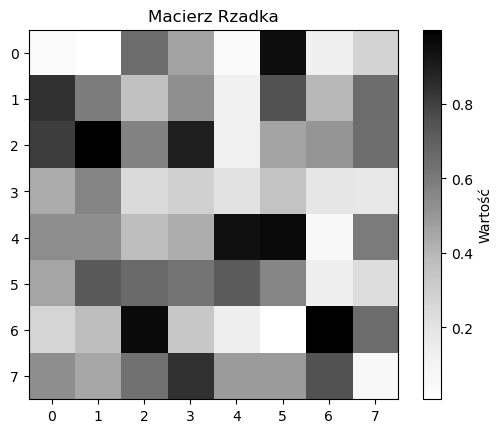

In [20]:
matrix = sparse_matrix(8, 8, 1)

wisualize_matrix(matrix)

In [35]:
matrix = sparse_matrix(8, 8, 0.5)
matrix

array([[0.87292654, 0.34712816, 0.33188647, 0.        , 0.87384452,
        0.18528125, 0.43051197, 0.        ],
       [0.        , 0.01520573, 0.        , 0.        , 0.        ,
        0.93605004, 0.        , 0.86608126],
       [0.62260958, 0.        , 0.48067952, 0.38761181, 0.        ,
        0.        , 0.81403099, 0.67065723],
       [0.57310861, 0.        , 0.38504632, 0.        , 0.77563064,
        0.        , 0.12156328, 0.        ],
       [0.5183385 , 0.        , 0.34417611, 0.14568113, 0.        ,
        0.        , 0.40638489, 0.70521945],
       [0.47620698, 0.98834122, 0.49923108, 0.        , 0.        ,
        0.81331071, 0.03988587, 0.        ],
       [0.27303414, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.4812804 , 0.        ],
       [0.        , 0.48181027, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17702039]])

In [36]:
compressed = create_tree(matrix, r=2, epsilon=10*-12)

In [37]:
decompressed = decompression(compressed)

In [38]:
decompressed

array([[0.87292654, 0.34712816, 0.33188647, 0.        , 0.87384452,
        0.18528125, 0.43051197, 0.        ],
       [0.        , 0.01520573, 0.        , 0.        , 0.        ,
        0.93605004, 0.        , 0.86608126],
       [0.62260958, 0.        , 0.48067952, 0.38761181, 0.        ,
        0.        , 0.81403099, 0.67065723],
       [0.57310861, 0.        , 0.38504632, 0.        , 0.77563064,
        0.        , 0.12156328, 0.        ],
       [0.5183385 , 0.        , 0.34417611, 0.14568113, 0.        ,
        0.        , 0.40638489, 0.70521945],
       [0.47620698, 0.98834122, 0.49923108, 0.        , 0.        ,
        0.81331071, 0.03988587, 0.        ],
       [0.27303414, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.4812804 , 0.        ],
       [0.        , 0.48181027, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17702039]])

In [39]:
print(diff(matrix, decompressed))

0.0
